# Generative Adversarial Networks (GANs): Shape and Number Generation

# 1.  Steps Involved in Training GANs 

# 2. Preparing Training Data
## 2.1 A Training Dataset that Forms An Exponential Growth Shape

In [156]:
import torch

torch.manual_seed(0)    #A
observations = 2048
train_data = torch.zeros((observations, 2))    #B 

train_data[:,0]=50*torch.rand(observations)    #C

train_data[:,1]=1.08**train_data[:,0]    #D

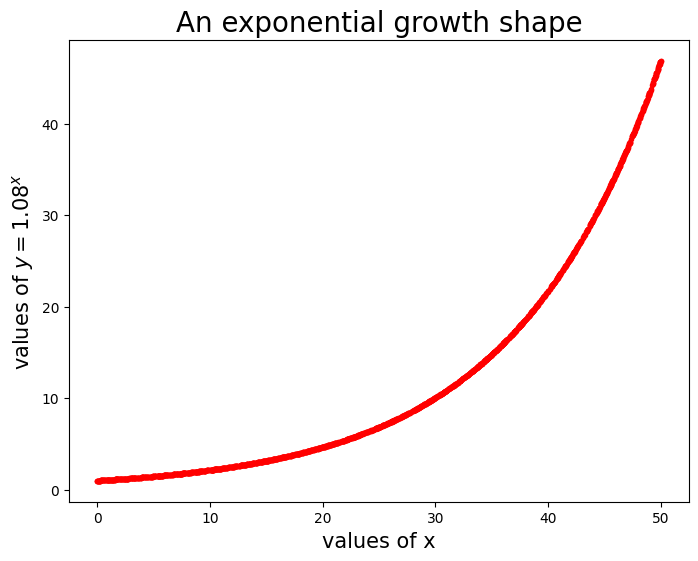

In [157]:
import matplotlib.pyplot as plt

fig=plt.figure(dpi=100,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")    #A
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=1.08^x$",fontsize=15)    #B
plt.title("An exponential growth shape",fontsize=20)    #C
plt.show()

## 2.2. Preparing the Training Dataset

In [158]:
from torch.utils.data import DataLoader

batch_size=128
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

In [159]:
batch0=next(iter(train_loader))
print(batch0)

tensor([[41.9333, 25.2099],
        [ 8.0561,  1.8589],
        [22.2487,  5.5416],
        [49.9585, 46.7522],
        [ 8.7647,  1.9631],
        [ 3.0979,  1.2692],
        [26.0517,  7.4259],
        [38.2393, 18.9716],
        [37.1300, 17.4191],
        [45.0543, 32.0541],
        [ 8.7989,  1.9683],
        [20.4796,  4.8362],
        [46.7506, 36.5243],
        [21.8242,  5.3635],
        [11.2329,  2.3738],
        [40.3307, 22.2845],
        [47.0477, 37.3691],
        [47.6369, 39.1026],
        [16.2331,  3.4880],
        [11.7535,  2.4709],
        [12.8855,  2.6958],
        [20.6749,  4.9095],
        [ 4.6602,  1.4314],
        [26.3385,  7.5916],
        [31.7039, 11.4727],
        [45.5565, 33.3172],
        [41.3369, 24.0788],
        [26.8584,  7.9015],
        [14.9879,  3.1692],
        [33.7039, 13.3817],
        [47.7350, 39.3988],
        [31.7714, 11.5324],
        [ 7.4853,  1.7790],
        [14.5973,  3.0754],
        [31.4056, 11.2122],
        [35.8166, 15

## 2.3. Creating Generative Adversarial Networks (GANs)

In [160]:
import torch.nn as nn

device="cuda" if torch.cuda.is_available() else "cpu"

D=nn.Sequential(
    nn.Linear(2,256),    #A
    nn.ReLU(),
    nn.Dropout(0.3),    #B
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),    #C
    nn.Sigmoid()).to(device)

In [161]:
G=nn.Sequential(
    nn.Linear(2,16),    #A
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)    #B

In [162]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

In [163]:
mse=nn.MSELoss()    #A

def performance(fake_samples):
    real=1.08**fake_samples[:,0]    #B
    mseloss=mse(fake_samples[:,1],real)   #C
    return mseloss

In [ ]:
class EarlyStop:
    def __init__(self, patience=1000):    #A
        self.patience = patience
        self.steps = 0
        self.min_gdif = float('inf')
    def stop(self, gdif):    #B
        if gdif < self.min_gdif:    #C
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        if self.steps >= self.patience:    #D
            return True
        else:
            return False

stopper=EarlyStop()


# 3. Train and Use GANs for Shape Generation

## 3.1. Train the GANs

In [165]:
real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [166]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)    #A
    loss_D=loss_fn(out_D,real_labels)    #B
    loss_D.backward()
    optimD.step()    #C
    return loss_D

In [167]:
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)     #A       
    optimD.zero_grad()
    out_D=D(fake_samples)    #B
    loss_D=loss_fn(out_D,fake_labels)    #C
    loss_D.backward()
    optimD.step()    #D
    return loss_D

In [168]:
def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)    #A
    out_G=D(fake_samples)    #B
    loss_G=loss_fn(out_G,real_labels)    #C
    loss_G.backward()
    optimG.step()     #D
    return loss_G, fake_samples 

In [169]:
import os
os.makedirs("files", exist_ok=True)    #A

def test_epoch(epoch,gloss,dloss,n,fake_samples):
    if epoch==0 or (epoch+1)%50==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}")    #B 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            alpha=0.1,label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")
        plt.show()

at epoch 1, G loss: 0.7837384541829427, D loss 0.8468931198120118


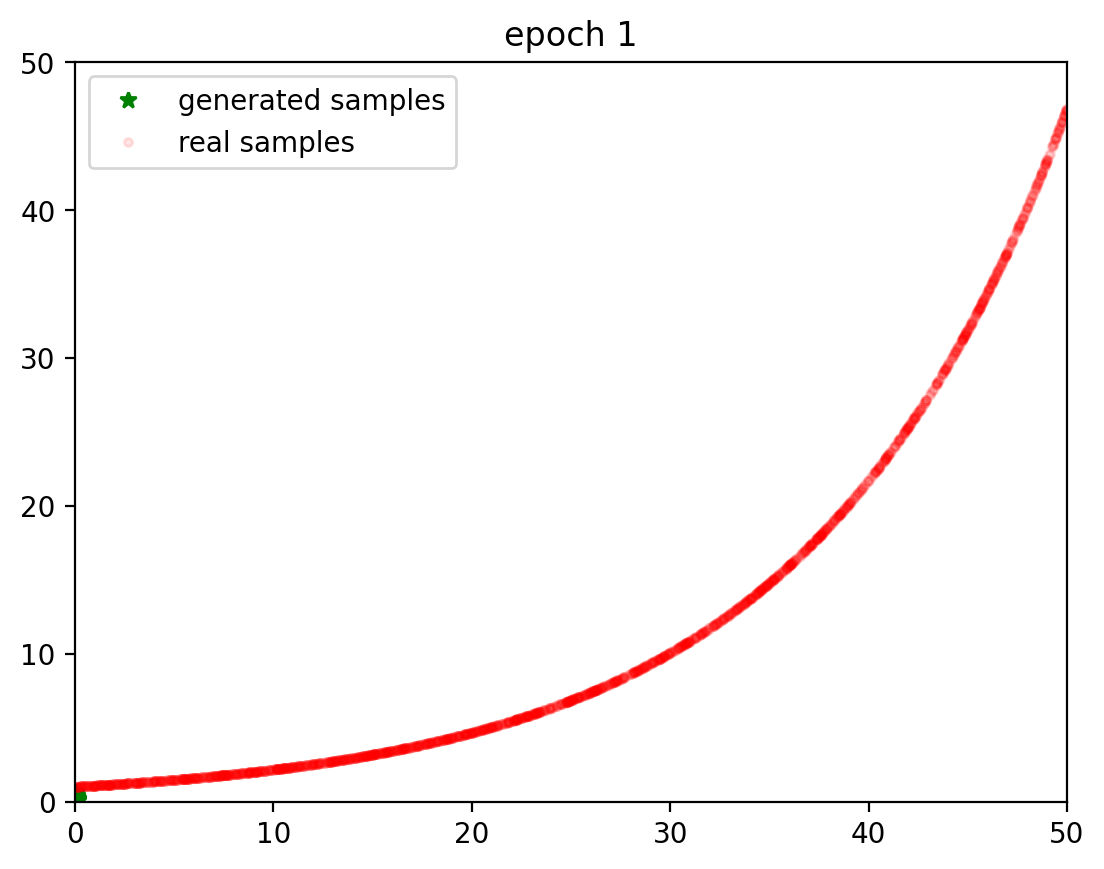

at epoch 50, G loss: 1.5289095560709636, D loss 0.8747215270996094


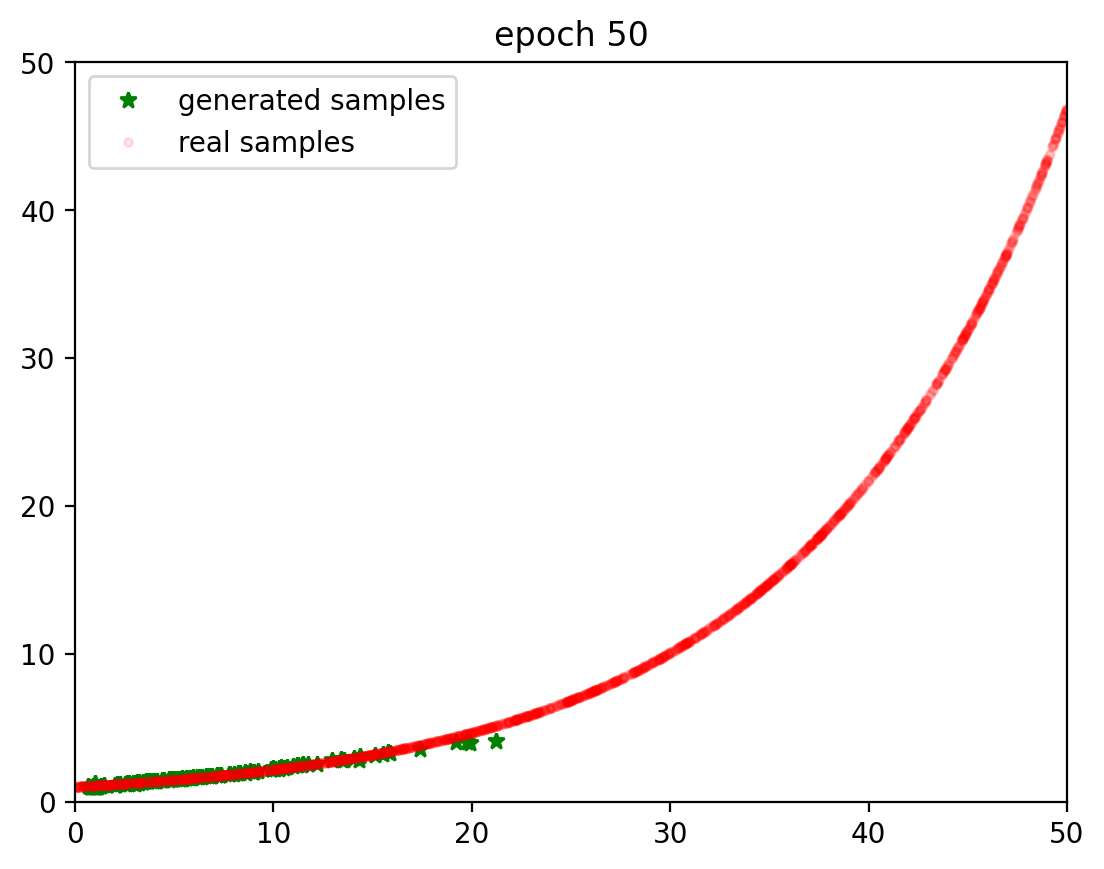

at epoch 100, G loss: 1.043695831298828, D loss 1.1569428761800131


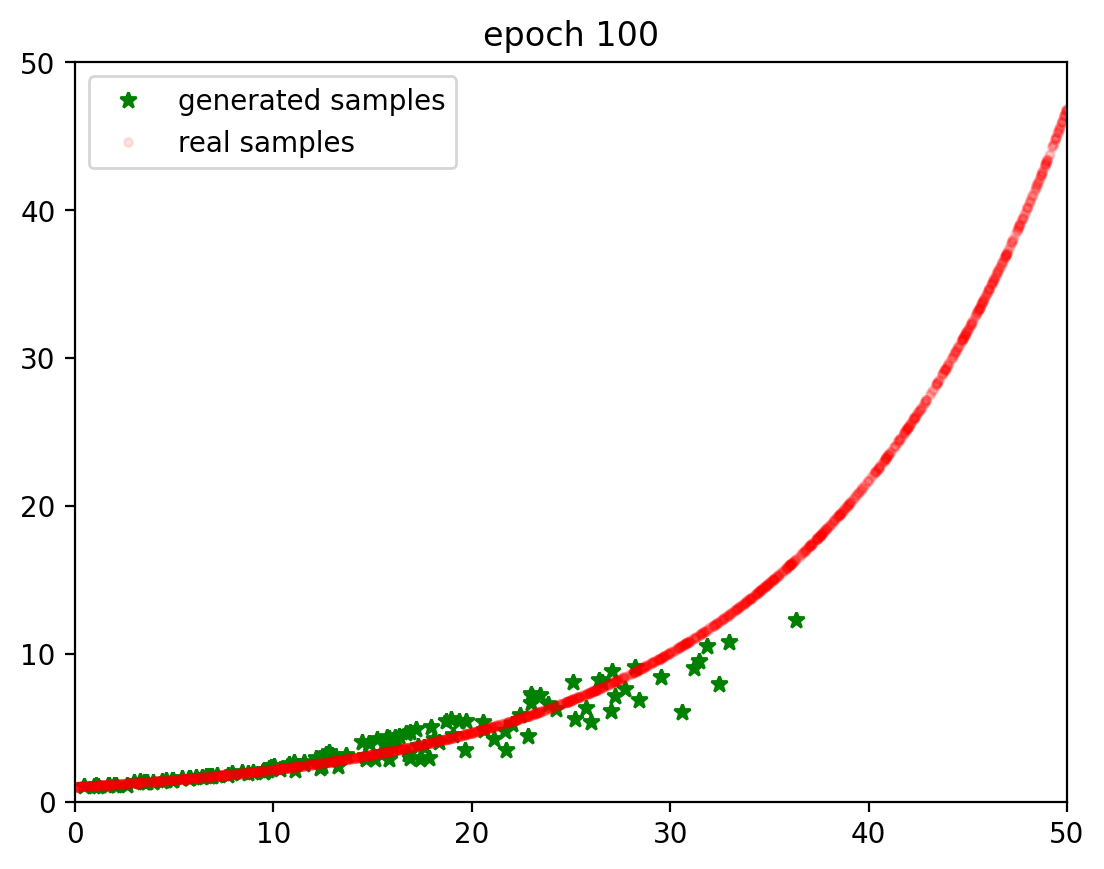

at epoch 150, G loss: 0.8738173166910808, D loss 1.3227752685546874


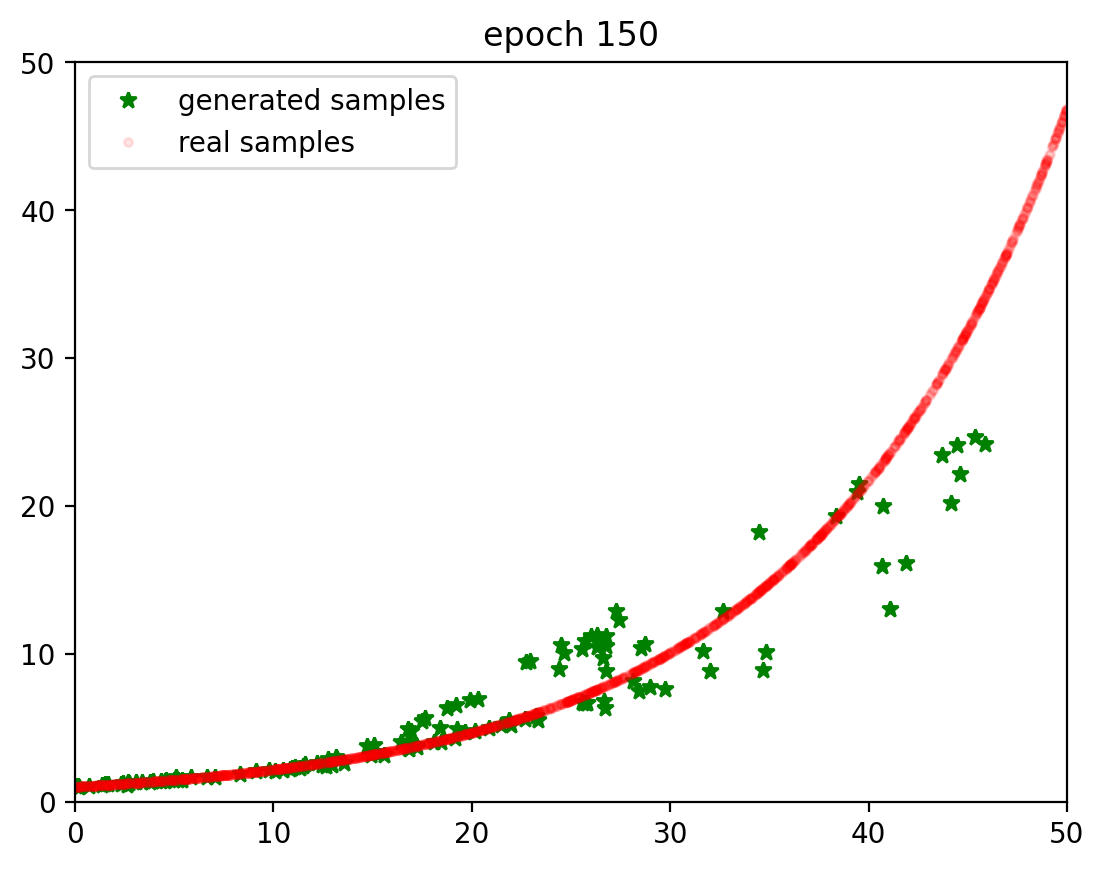

at epoch 200, G loss: 0.8123301188151042, D loss 1.4343879699707032


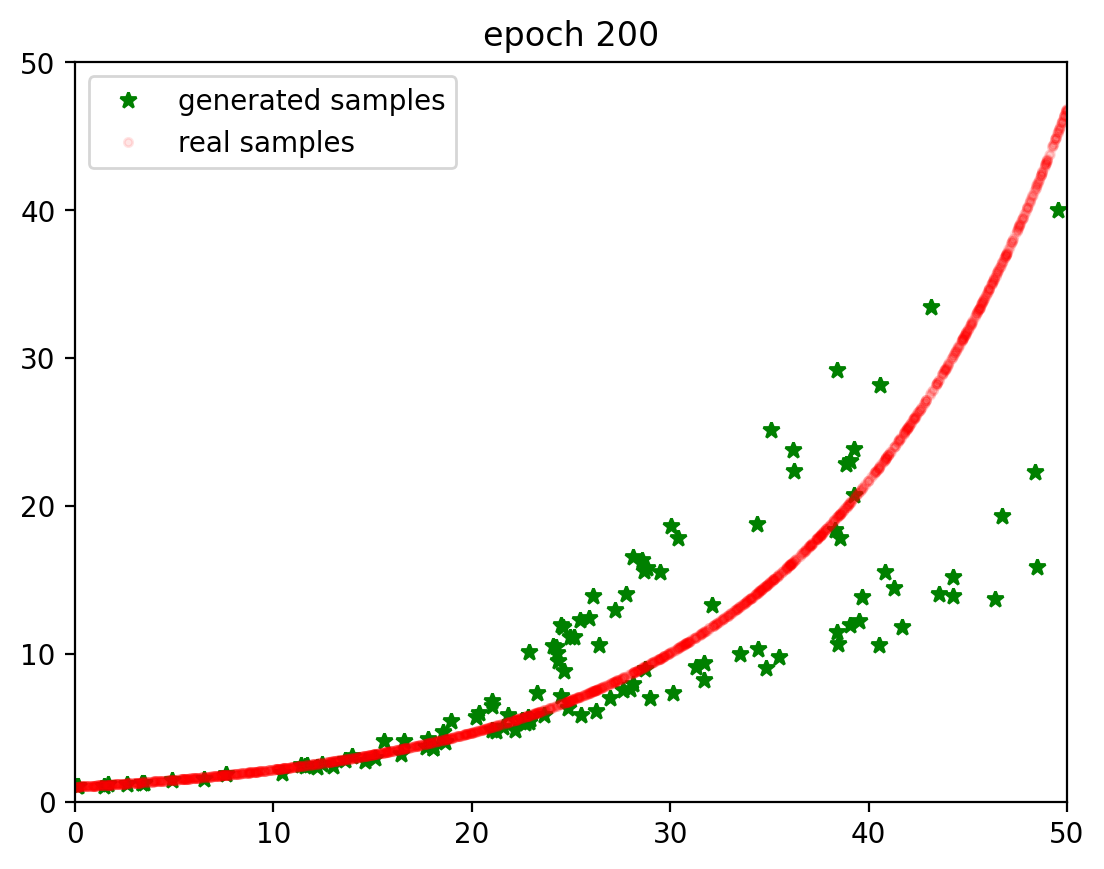

at epoch 250, G loss: 0.7703135172526042, D loss 1.4779661814371745


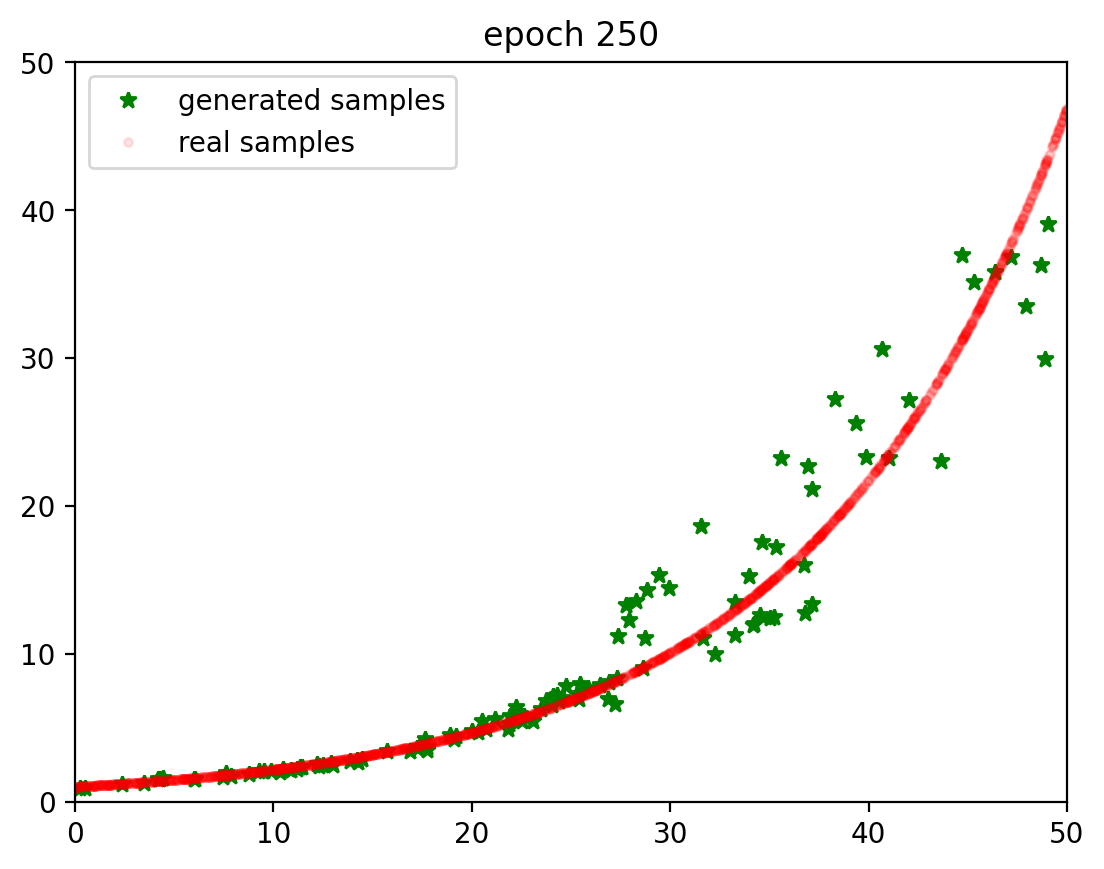

at epoch 300, G loss: 0.7628003438313802, D loss 1.4747692108154298


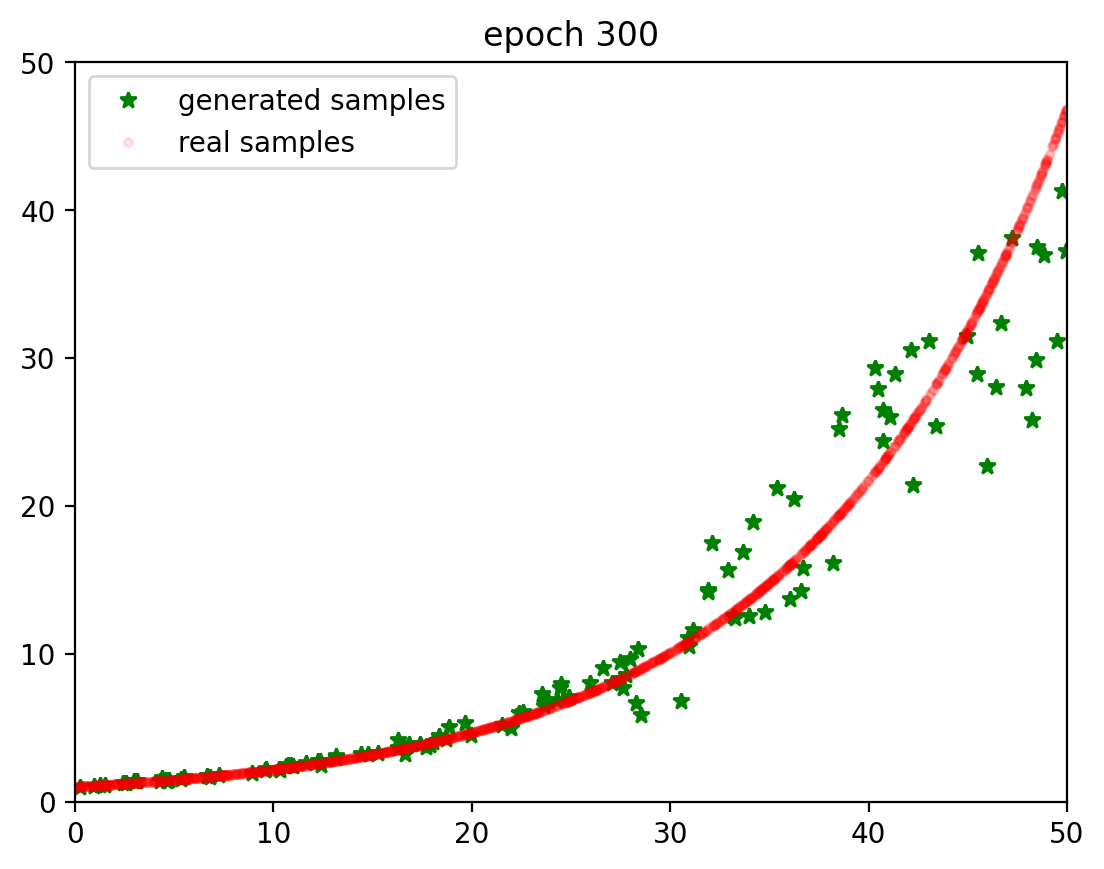

at epoch 350, G loss: 0.7527135848999024, D loss 1.4743356068929037


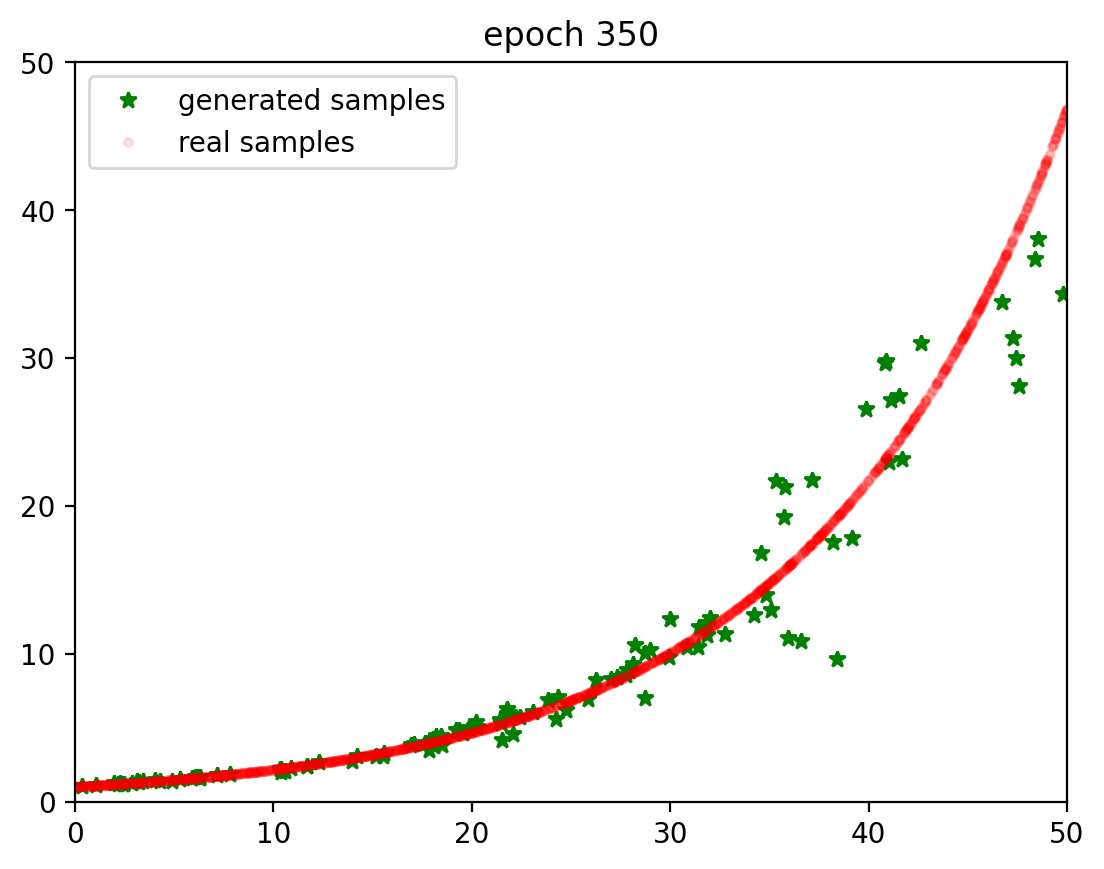

at epoch 400, G loss: 0.7598826090494791, D loss 1.477519734700521


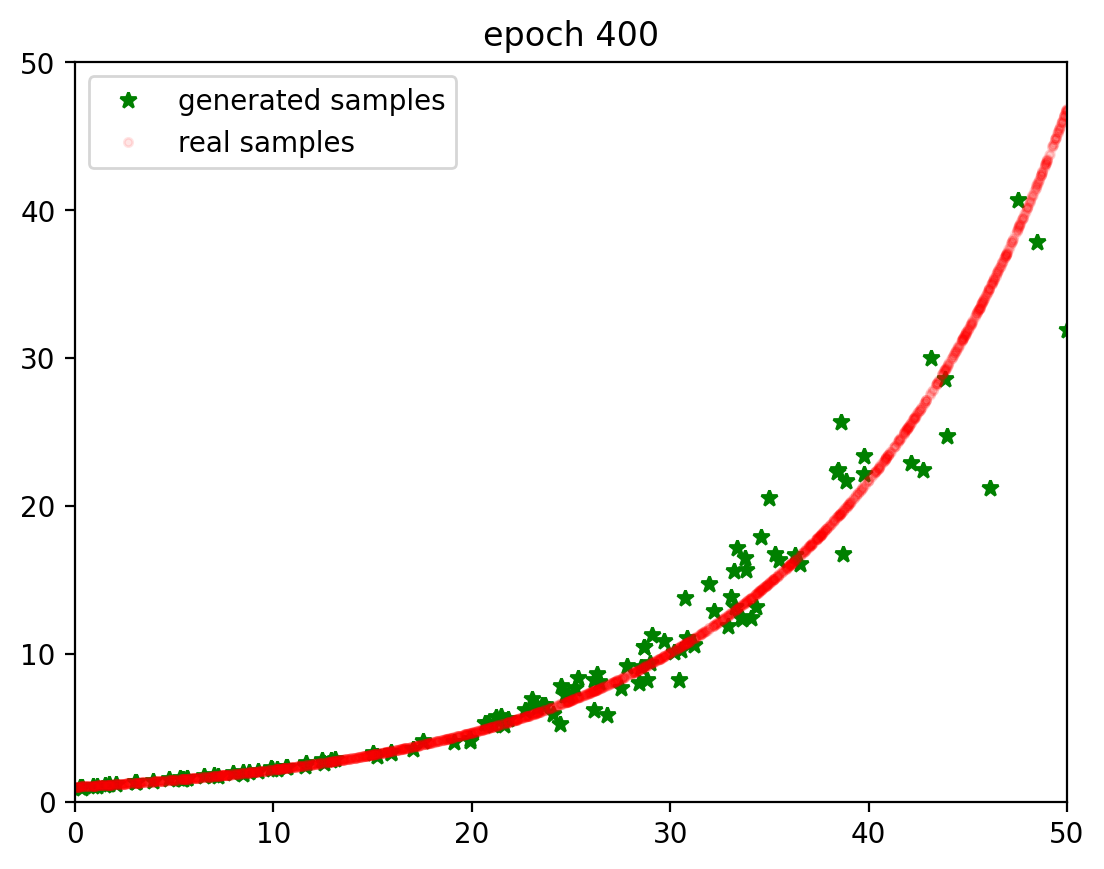

at epoch 450, G loss: 0.7555384953816732, D loss 1.4772382100423178


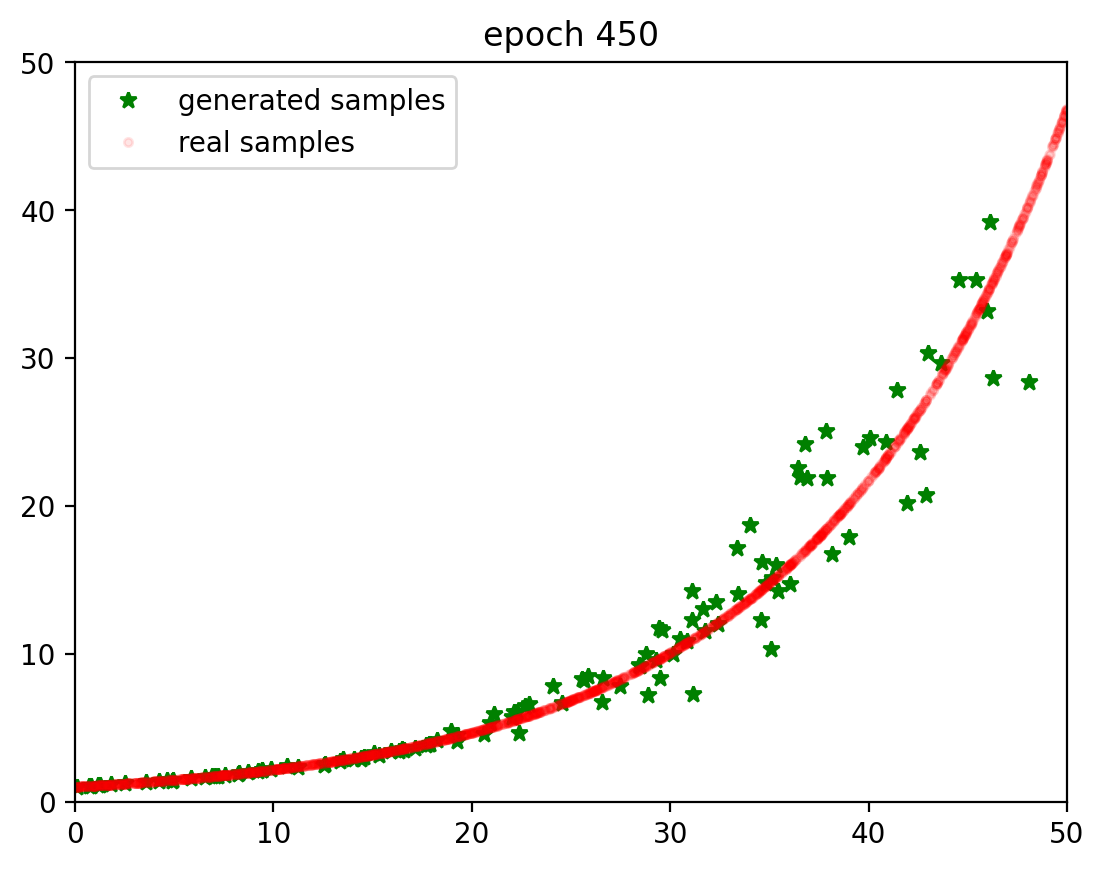

at epoch 500, G loss: 0.7505151748657226, D loss 1.4792802174886068


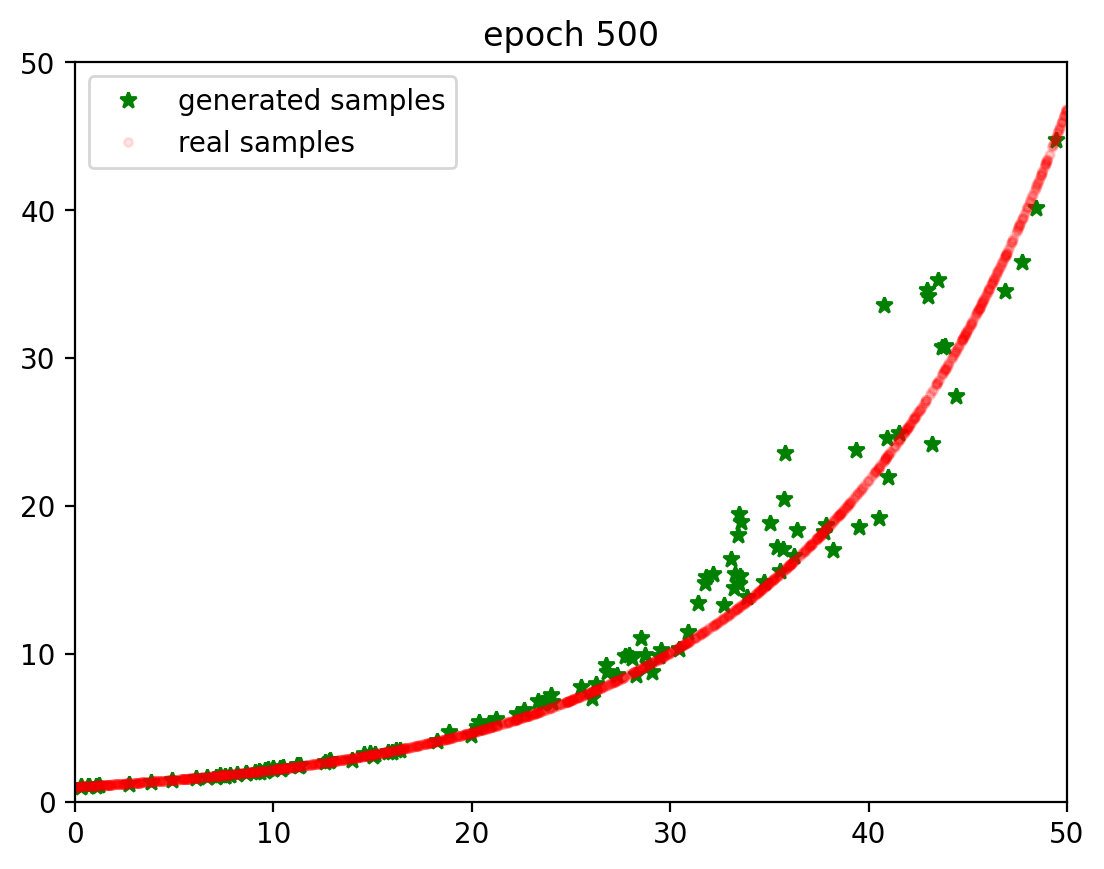

at epoch 550, G loss: 0.753008778889974, D loss 1.4748671213785807


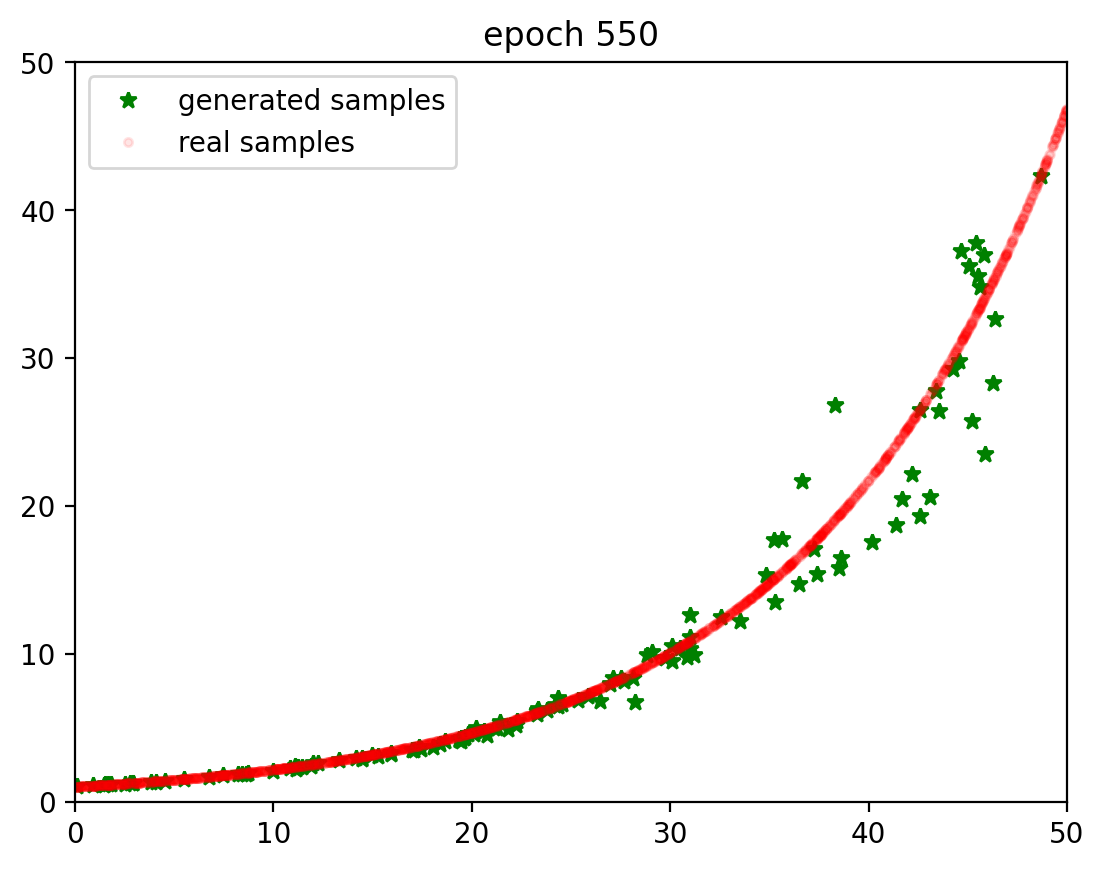

at epoch 600, G loss: 0.7571940739949544, D loss 1.4748818715413412


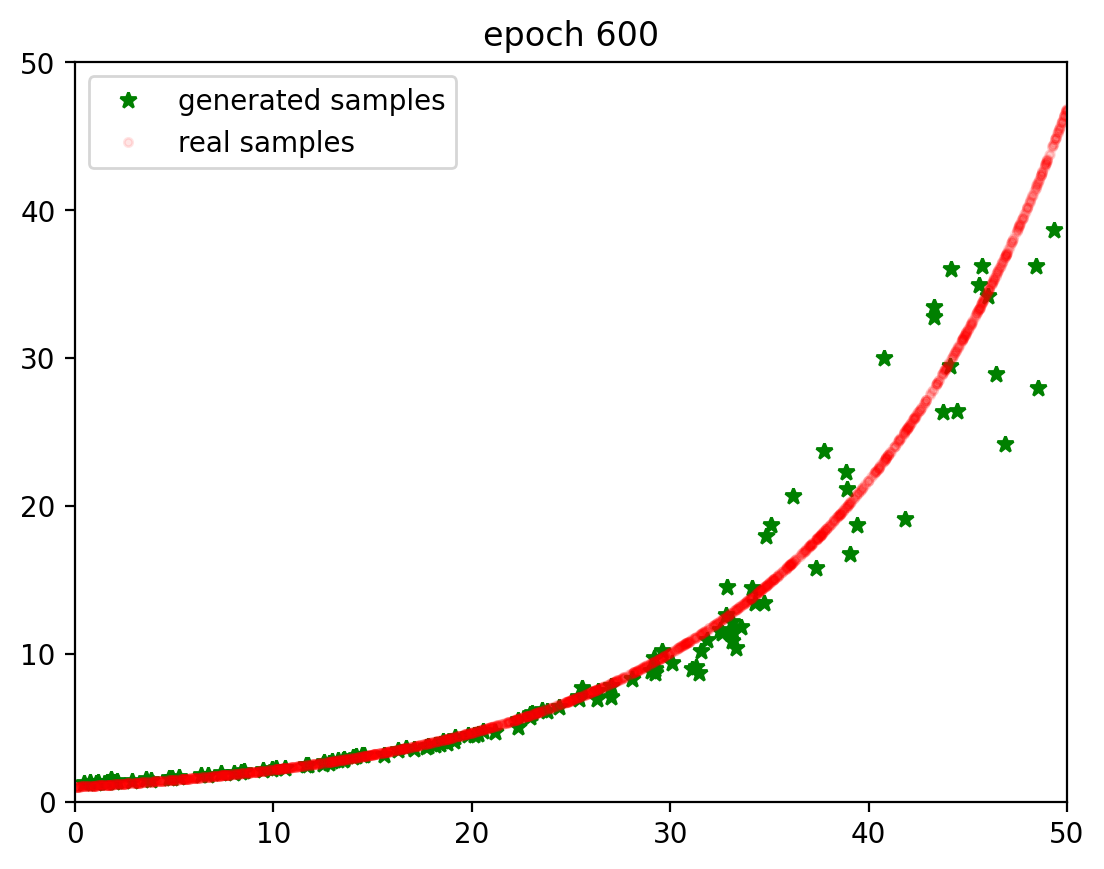

at epoch 650, G loss: 0.7459877014160157, D loss 1.4730915069580077


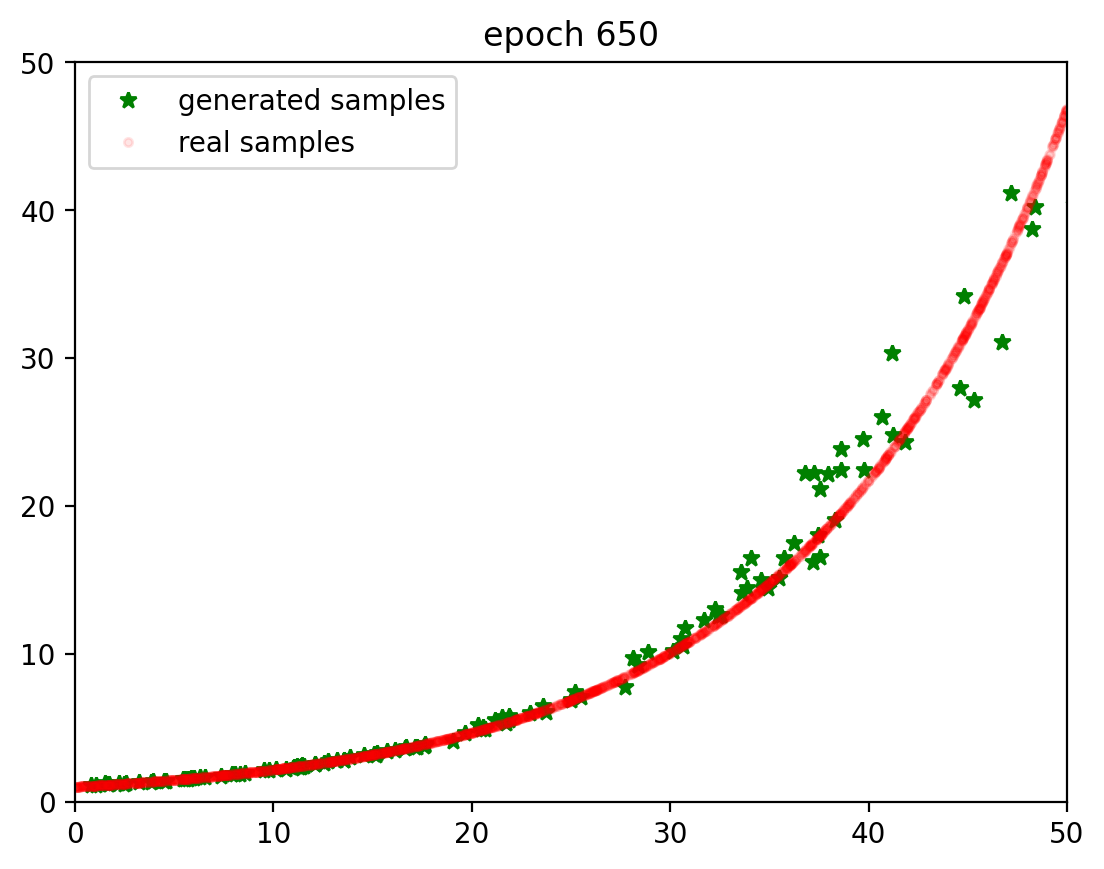

at epoch 700, G loss: 0.7559837977091471, D loss 1.474233373006185


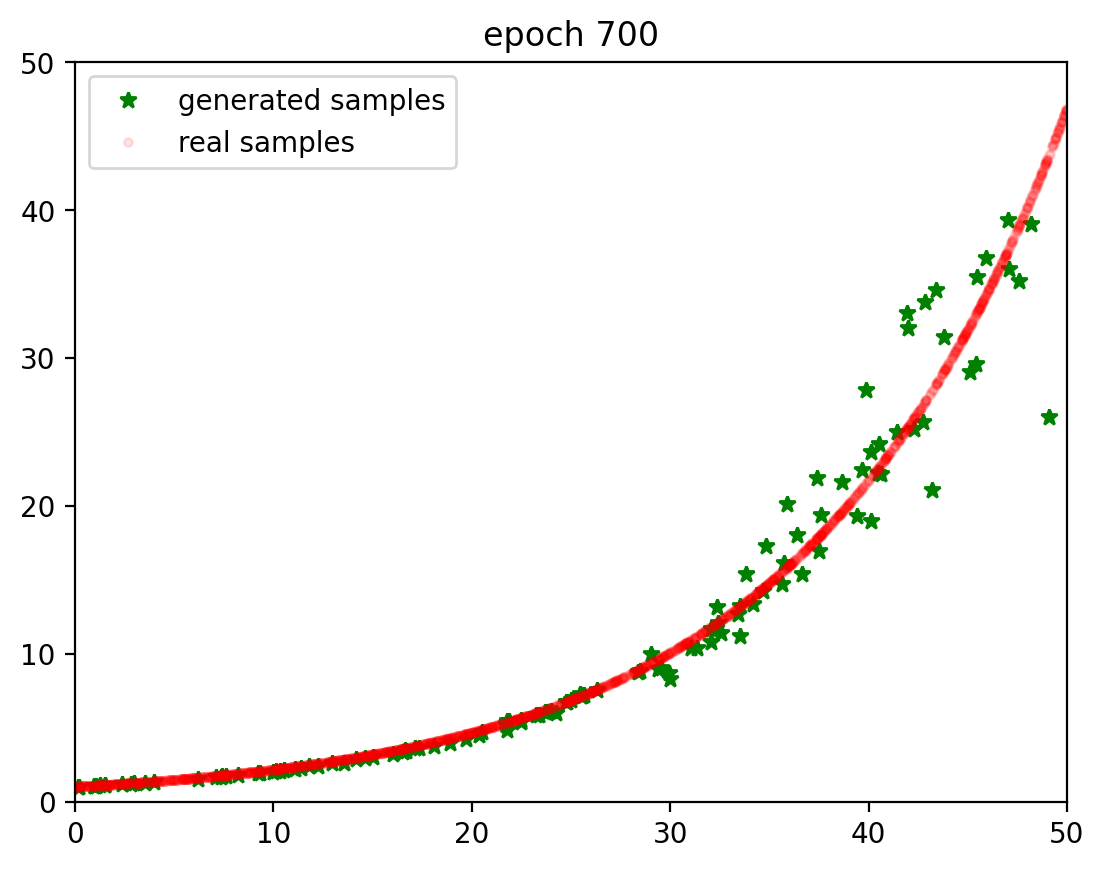

at epoch 750, G loss: 0.7595476150512696, D loss 1.473736572265625


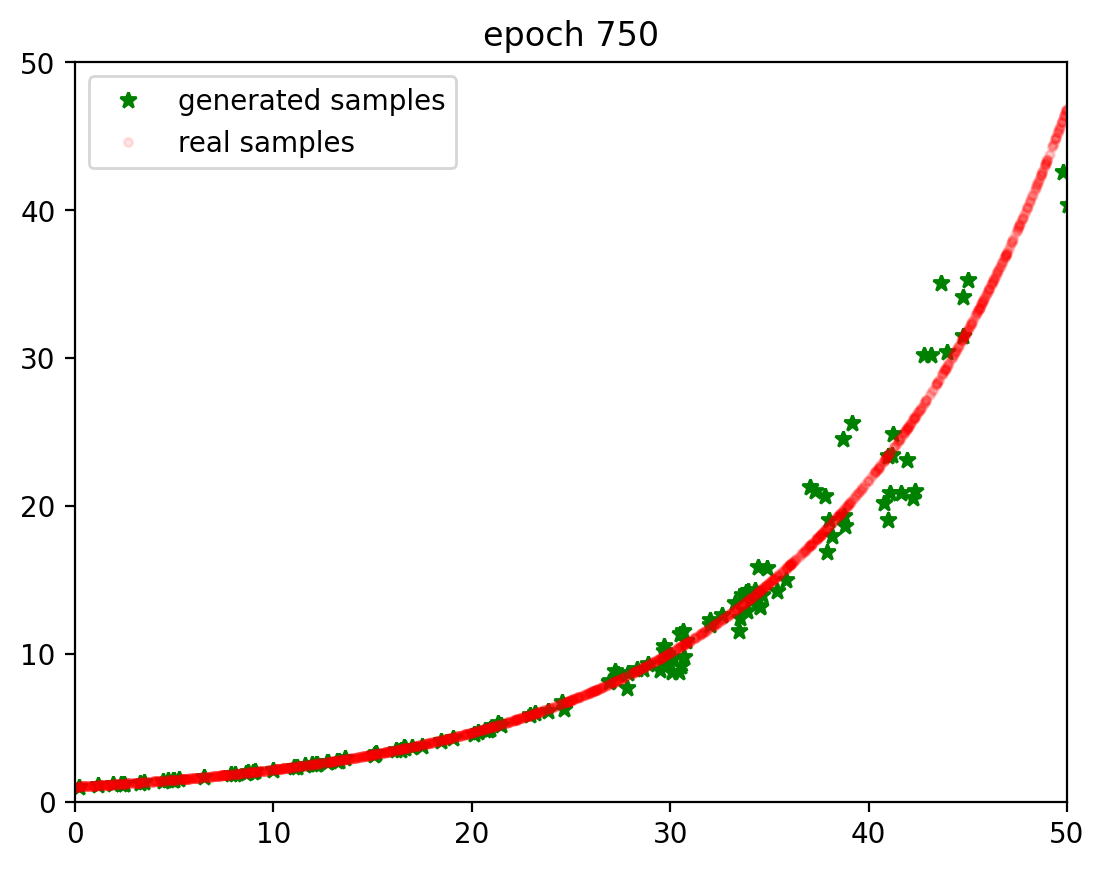

at epoch 800, G loss: 0.7503208796183268, D loss 1.4751283009847005


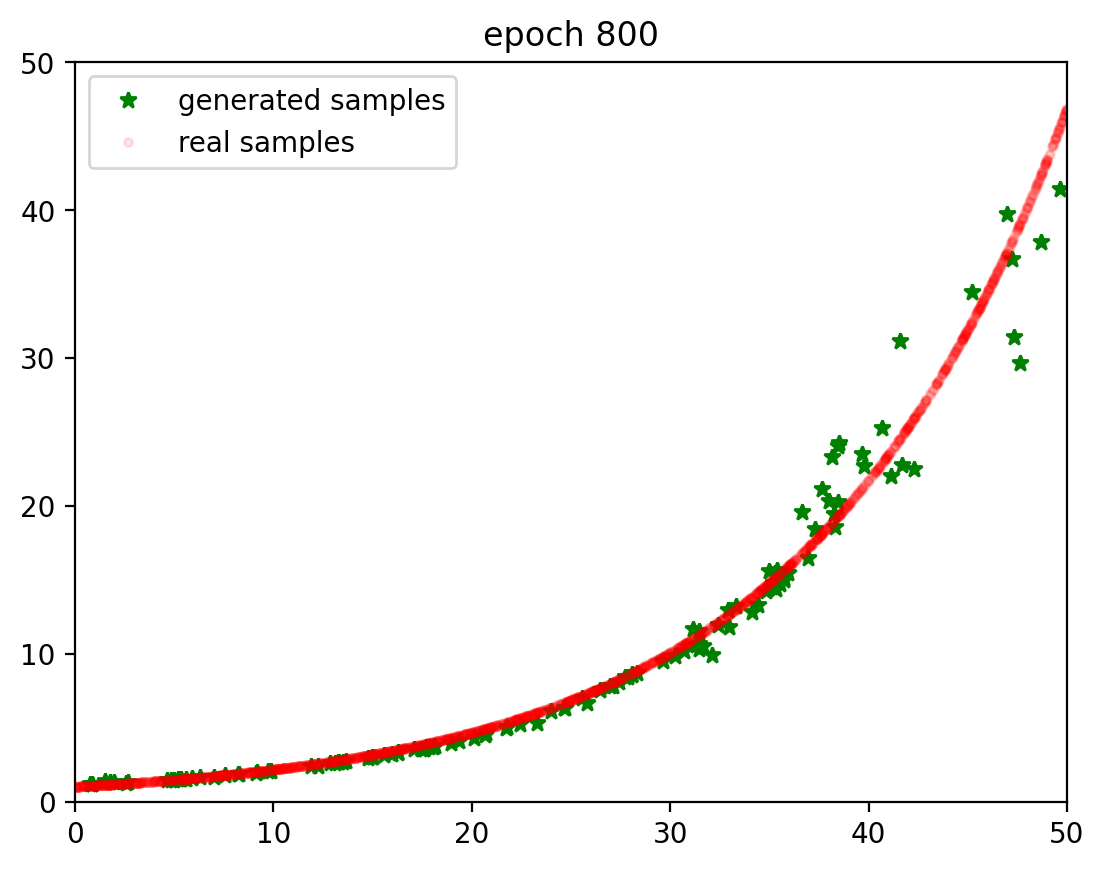

at epoch 850, G loss: 0.7495262781778972, D loss 1.4760720570882162


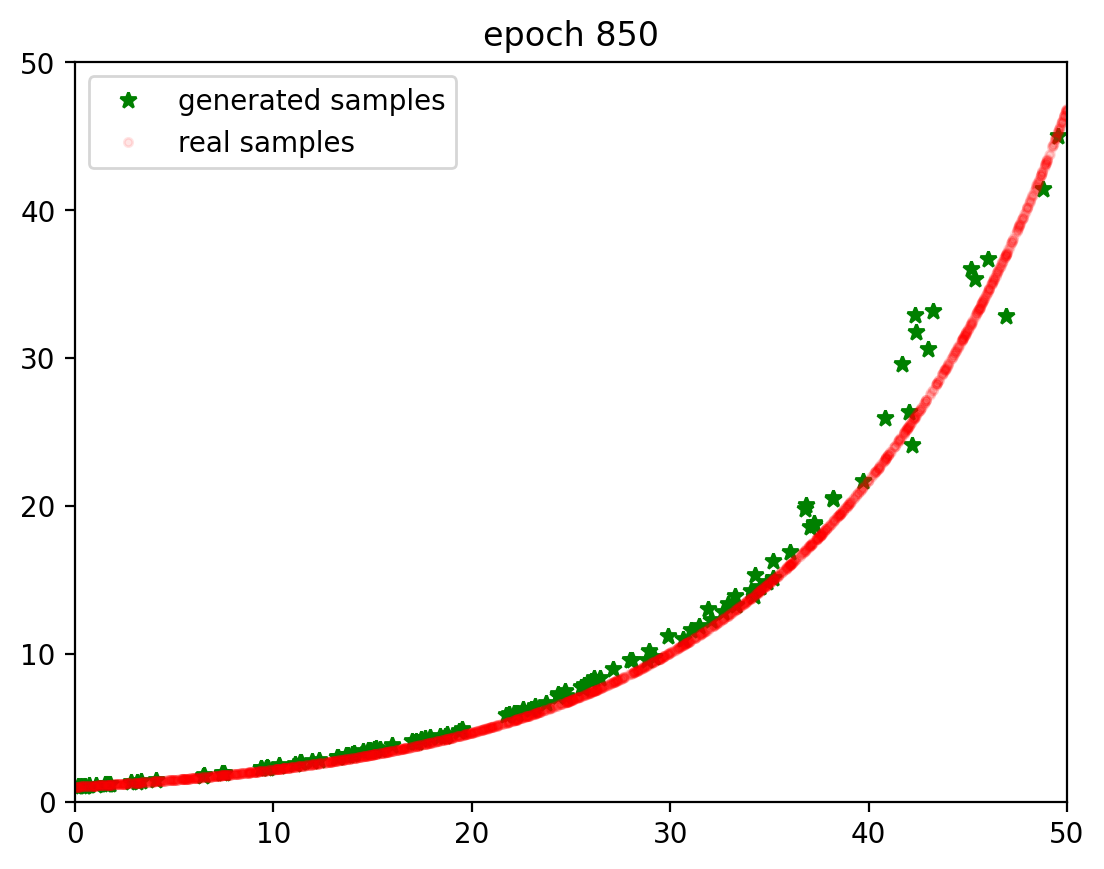

at epoch 900, G loss: 0.7501949310302735, D loss 1.4695177714029948


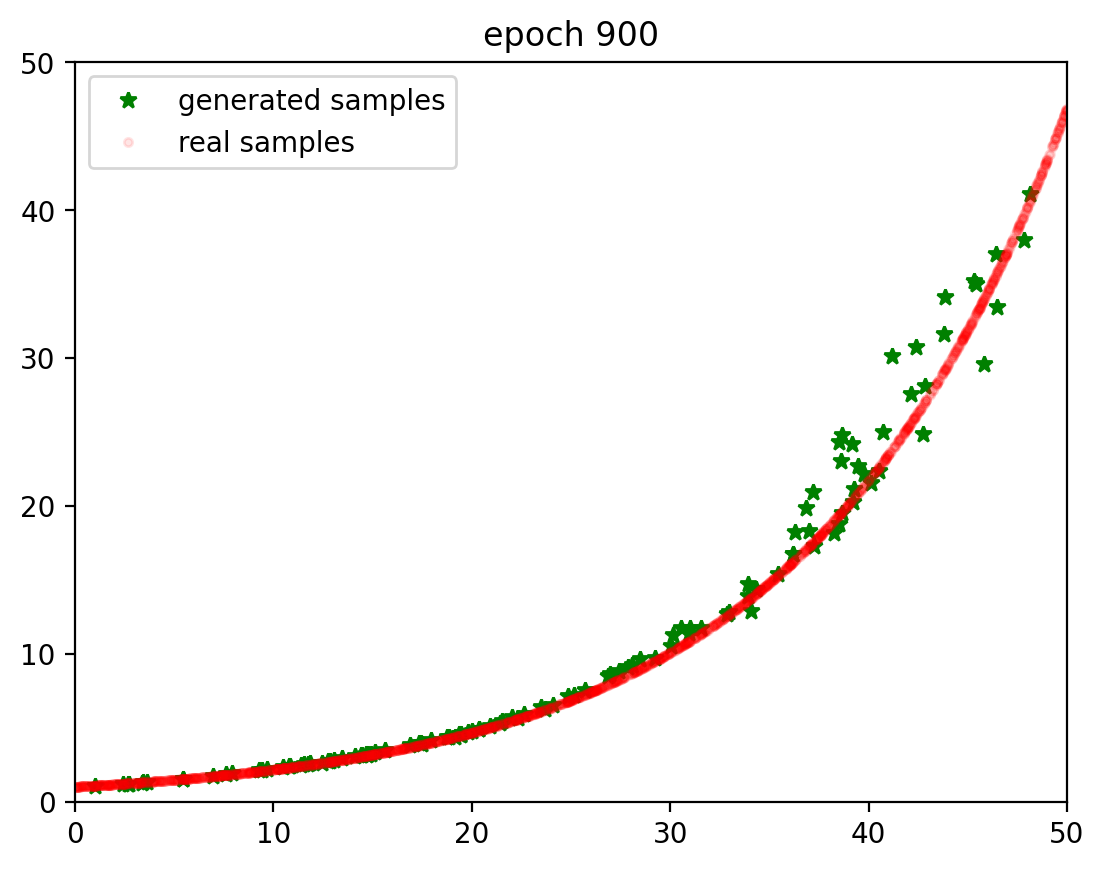

at epoch 950, G loss: 0.7540910085042317, D loss 1.473730977376302


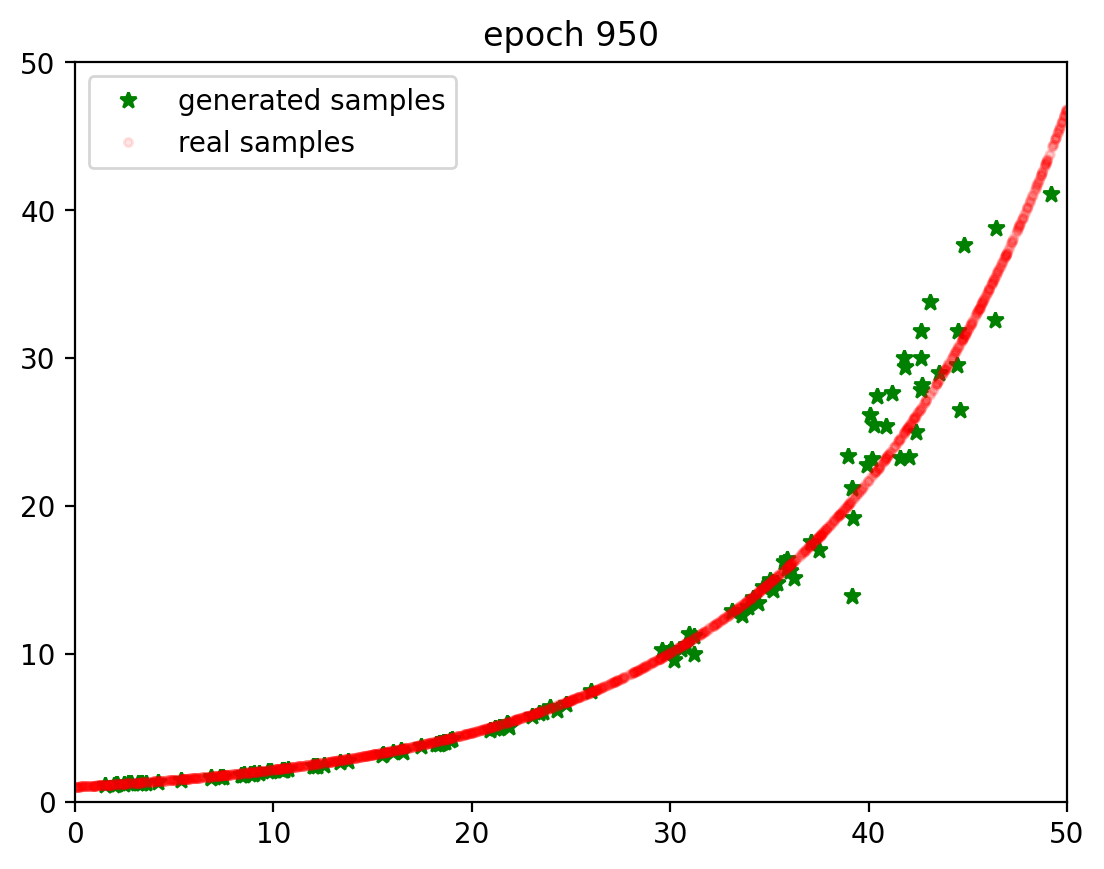

at epoch 1000, G loss: 0.7598566691080729, D loss 1.4670252482096353


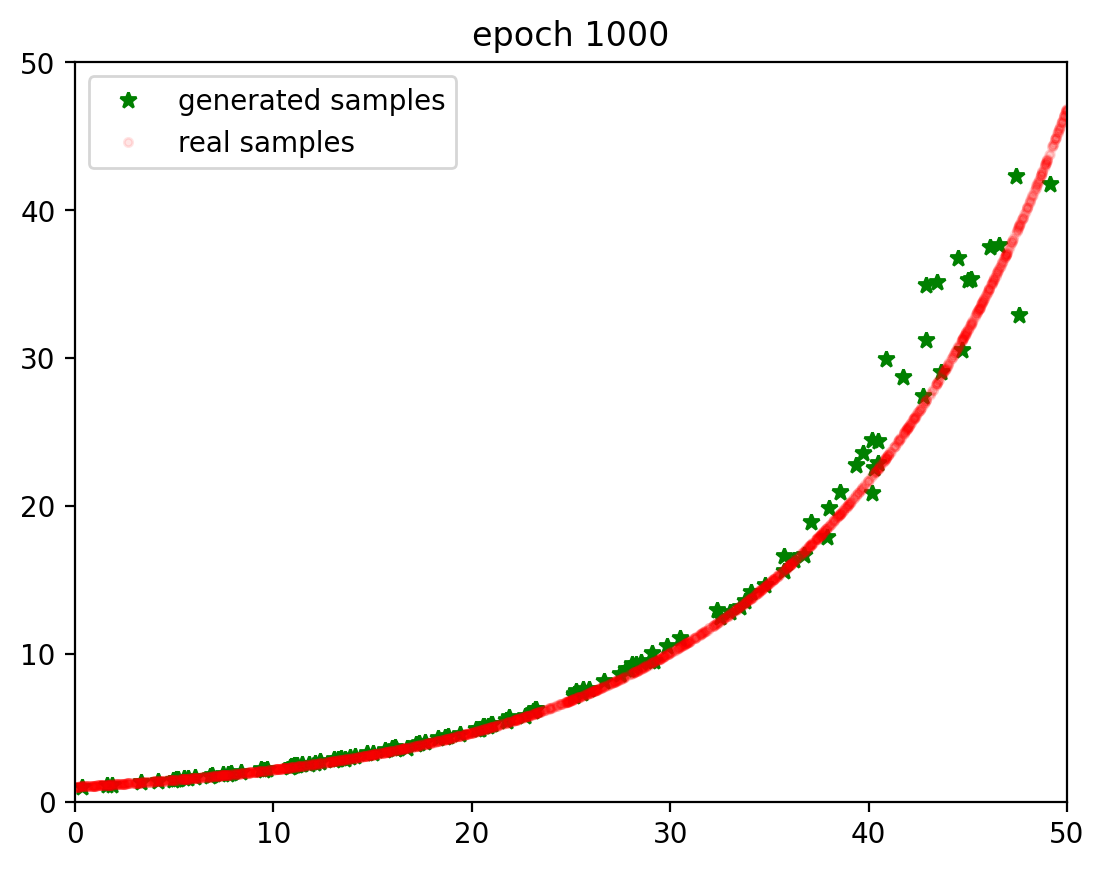

In [170]:
for epoch in range(10000):    #A
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):    #B
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n,fake_samples)    #C
    gdif=performance(fake_samples).item()
    if stopper.stop(gdif)==True:    #D
        break

## 3.2. Save and Use the Trained Model

In [171]:
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(G) 
scripted.save('files/exponential.pt') 

In [172]:
new_G=torch.jit.load('files/exponential.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [173]:
noise=torch.randn((batch_size,2)).to(device)
new_data=new_G(noise) 

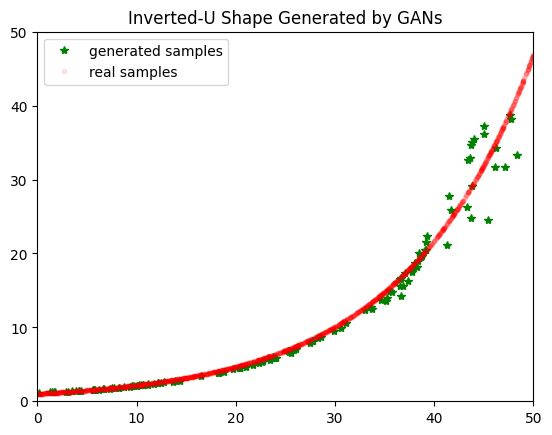

In [174]:
fig=plt.figure(dpi=100)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],"*",c="g",
        label="generated samples")    #A
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         alpha=0.1,label="real samples")    #B
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(0,50)
plt.ylim(0,50)
plt.legend()
plt.show()

In [194]:
# exercise 3.1
import torch

torch.manual_seed(0)    
observations = 2048
train_data = torch.zeros((observations, 2))    
train_data[:,0]=10*(torch.rand(observations)-0.5)  
train_data[:,1]=torch.sin(train_data[:,0])  

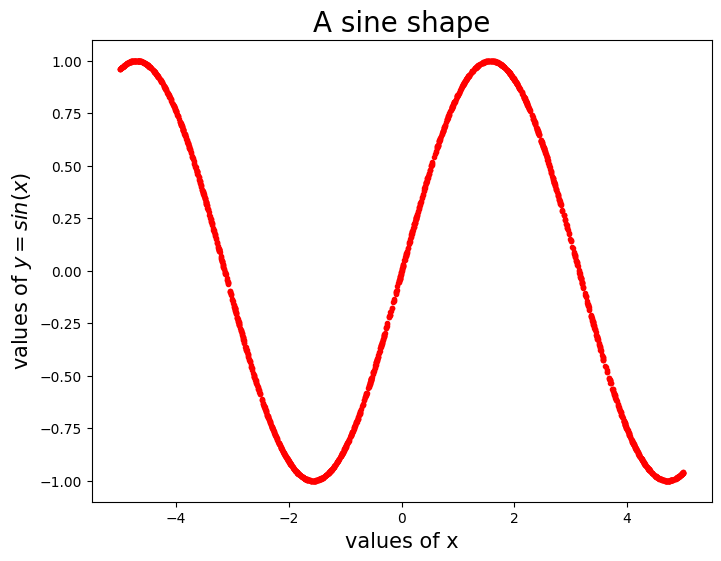

In [195]:
# exercise 3.2
import matplotlib.pyplot as plt

fig=plt.figure(dpi=100,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=sin(x)$",fontsize=15)
plt.title("A sine shape",fontsize=20)
plt.show()

at epoch 0, G loss: 0.7281676876929498, D loss 1.0012835225751322


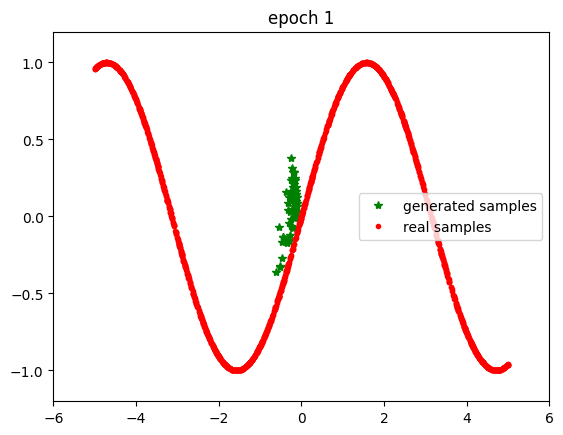

at epoch 24, G loss: 1.1344966273153982, D loss 1.1344646330802672


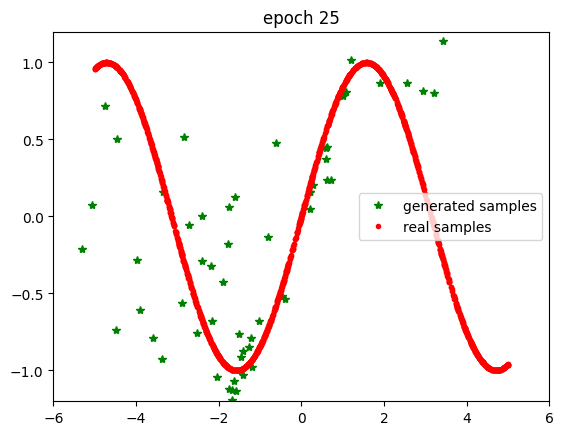

at epoch 49, G loss: 0.9503439011112336, D loss 1.1978239244030369


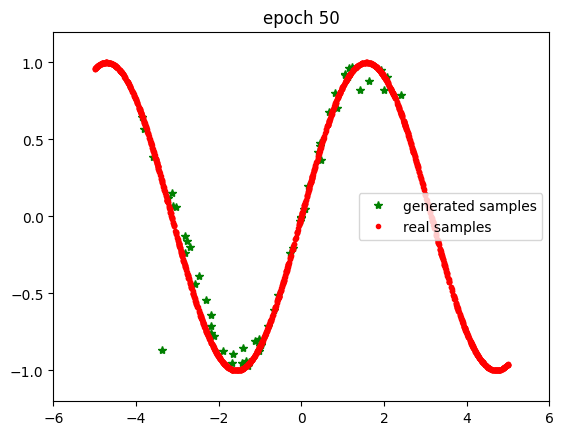

at epoch 74, G loss: 0.7887437881961945, D loss 1.3679382570328251


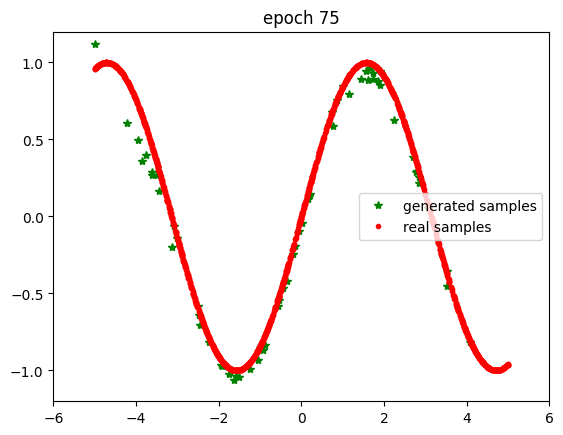

at epoch 99, G loss: 0.7753080552624118, D loss 1.383178957047001


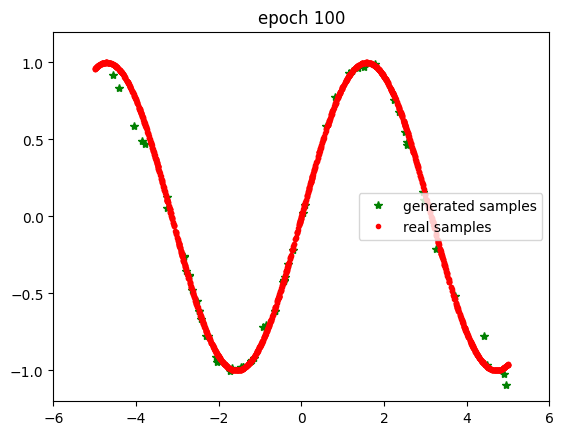

at epoch 124, G loss: 0.7834841820501512, D loss 1.3816607075352823


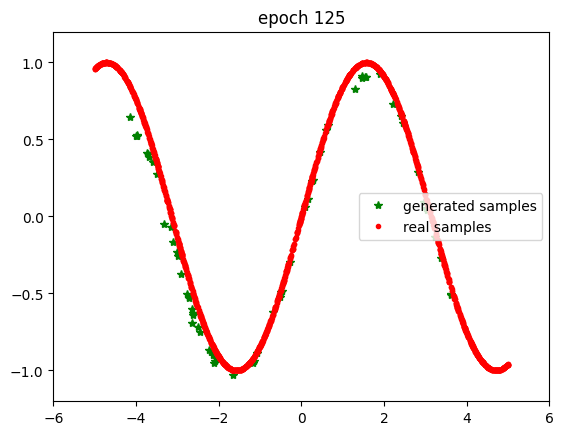

at epoch 149, G loss: 0.7683755197832661, D loss 1.3843399786180066


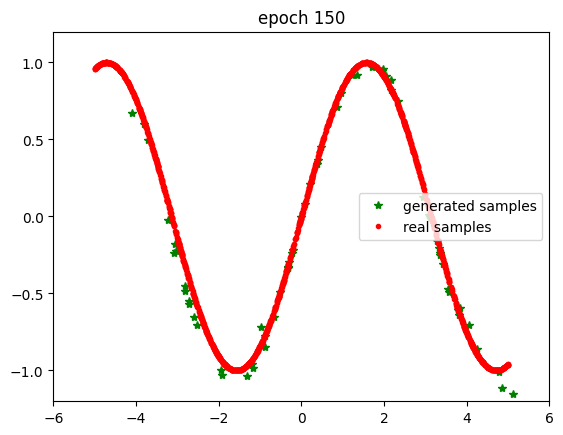

at epoch 174, G loss: 0.7619663361580141, D loss 1.3927133621708039


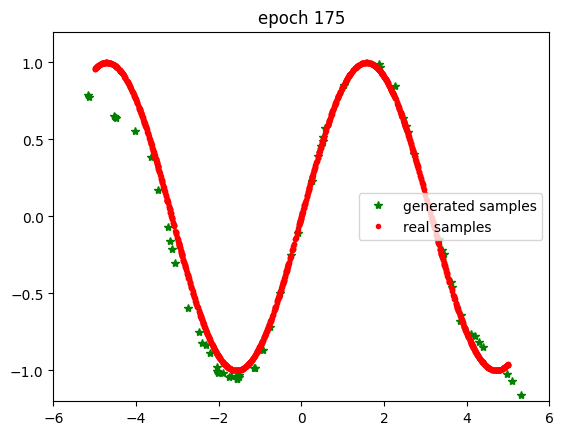

at epoch 199, G loss: 0.7472096720049458, D loss 1.4136112582299016


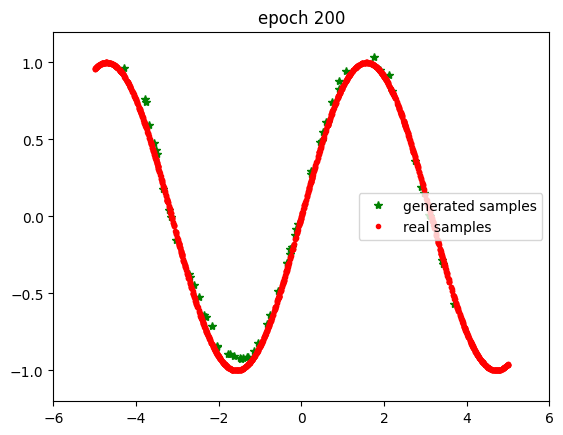

at epoch 224, G loss: 0.748258775280368, D loss 1.4095826918079006


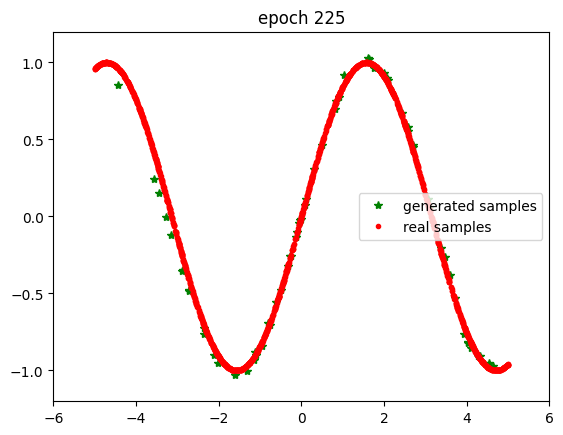

at epoch 249, G loss: 0.7355993947675151, D loss 1.4166297912597656


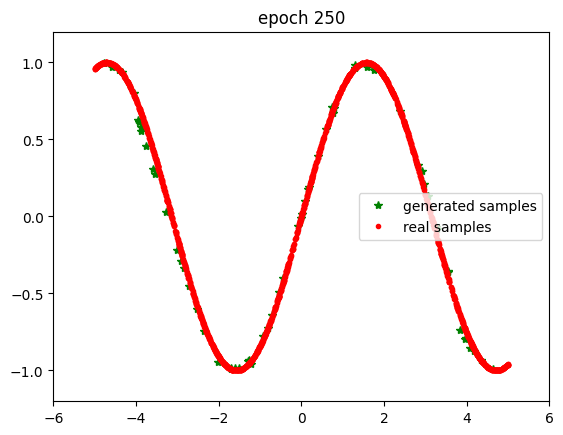

at epoch 274, G loss: 0.7221514178860572, D loss 1.4228836797898816


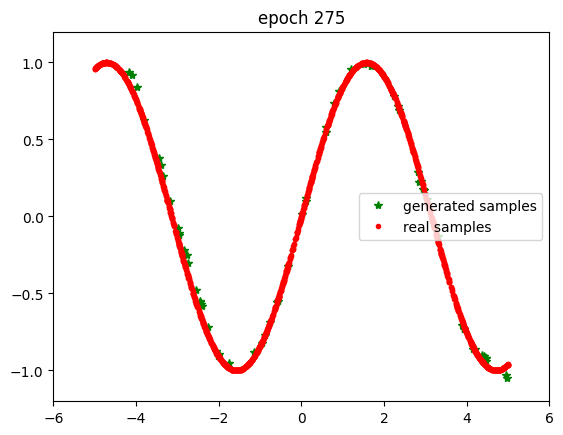

at epoch 299, G loss: 0.7259412580920804, D loss 1.4287403475853704


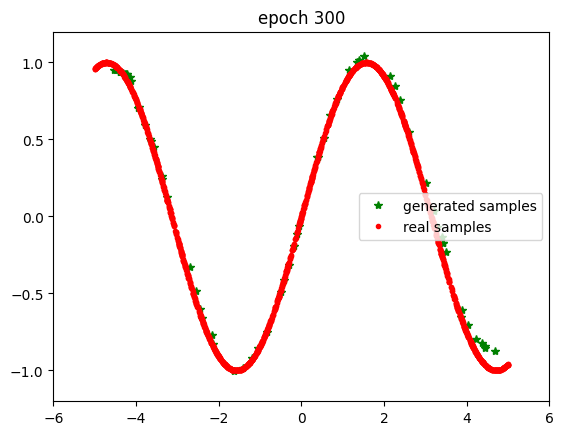

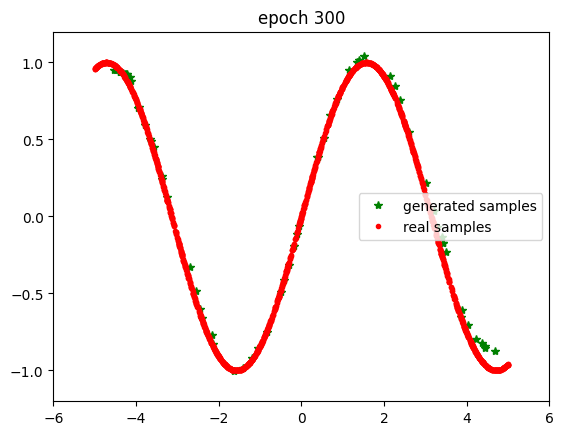

In [196]:
# exercise 3.3
from torch.utils.data import DataLoader

batch_size=64
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

import torch.nn as nn
device="cuda" if torch.cuda.is_available() else "cpu"
D=nn.Sequential(
    nn.Linear(2,256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),
    nn.Sigmoid()).to(device)
G=nn.Sequential(
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)

loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)
    loss_D=loss_fn(out_D,real_labels)
    loss_D.backward()
    optimD.step()
    return loss_D
        
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)        
    optimD.zero_grad()
    out_D=D(fake_samples)
    loss_D=loss_fn(out_D,fake_labels)
    loss_D.backward()
    optimD.step()
    return loss_D

def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)
    out_G=D(fake_samples)
    loss_G=loss_fn(out_G,real_labels)
    loss_G.backward()
    optimG.step() 
    return loss_G, fake_samples 

import os
os.makedirs("files", exist_ok=True)

def test_epoch(epoch,gloss,dloss,n):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch}, G loss: {g}, D loss {d}") 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=100)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            label="real samples")
        plt.title(f"epoch {epoch+1}")
        plt.xlim(-6,6)
        plt.ylim(-1.2,1.2)
        plt.legend()
        plt.show()

for epoch in range(300):
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n)
    
fake=fake_samples.detach().cpu().numpy()  
plt.figure(dpi=100)
plt.plot(fake[:,0],fake[:,1],"*",c="g",
    label="generated samples")
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
    label="real samples")
plt.title(f"epoch {epoch+1}")
plt.xlim(-6,6)
plt.ylim(-1.2,1.2)
plt.legend()
plt.show()       